In [38]:
suppressMessages(library("rwwa"))

# Make model eval results useable

In [4]:
ev_cats <- c("r" = "reasonable", "b" = "bad", "g" = "good")

In [5]:
framing <- "cordex"

if (framing == "cordex") {
    mlist <- gsub(".+jjaso_|.dat","",list.files(paste0("ts-",framing), pattern = "jjaso"))
} else {
    mlist <- gsub(".+jjaso_|_r1i.+","",list.files(paste0("ts-",framing), pattern = "jjaso"))
}
ev <- read.csv(paste0("mdl-eval/Model validation - ",framing,".csv"), row.names = 1)[mlist,]
ev[,1] <- ev_cats[ev[,1]]
ev[,2] <- ev_cats[substr(ev[,2],1,1)]

write.csv(ev, paste0("mdl-eval/eval-seasonal-spatial_",framing,".csv"))

# Compile obs

In [41]:
for (mtype in c("gmst-only", "gmst+nino")) {
    for (varnm in c("rx3day", "pr-jjaso")) {
        res_obs <- t(sapply(list.files("res-obs", pattern = paste0("res-obs_",varnm, "_",gsub("gmst\\+",".+",mtype)), full.names = T), function(fnm) {
            res <- read.csv(fnm, row.names = "X")
            unlist(lapply(rownames(res), function(cnm) setNames(res[cnm,], paste(gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))
        }))
        rownames(res_obs) <- gsub(paste0(".+",mtype,"_|.csv"),"",rownames(res_obs))
        write.csv(res_obs, paste0("res-obs_",varnm,"_",mtype,".csv"))
    }
}

In [21]:
# Results for 1979-only fit 
for (mtype in c("gmst-only", "gmst+nino")) {
    for (varnm in c("pr-jjaso")) {
        res_obs <- t(sapply(list.files("res-obs", pattern = paste0("res-1979_",varnm, "_",gsub("gmst\\+",".+",mtype)), full.names = T), function(fnm) {
            res <- read.csv(fnm, row.names = "X")
            unlist(lapply(rownames(res), function(cnm) setNames(res[cnm,], paste(gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))
        }))
        rownames(res_obs) <- gsub(paste0(".+_|.csv"),"",rownames(res_obs))
        write.csv(res_obs, paste0("res-1979_",varnm,"_",mtype,".csv"))
    }
}

### Quick table of results

In [28]:
obs_res <- read.csv("res-1979_pr-jjaso_gmst-only.csv", row.names = "X")

In [ ]:
# loop over those variables, process those columns into a string
eval_cnm <- c("return.period", "PR.pi", "dI.rel.pi", "aic")

In [35]:
sapply(eval_cnm, function(ec) {
    obs_eval <- signif(obs_res[,grepl(ec, colnames(obs_res))], 2)
    apply(obs_eval, 1, function(r) paste0(r[1], " (",r[2], " to ", r[3], ")"))
})

,return.period,PR.pi,dI.rel.pi,aic
chirps,10 (2.5 to 660),2 (0.01 to 140),5 (-22 to 35),550 (520 to 560)
cpc,14 (4.2 to 380),0.26 (0.0053 to 2.4),-12 (-33 to 8.3),600 (580 to 610)
era5,6.8 (2.6 to 66),2.3 (0.092 to 110),6.7 (-16 to 33),590 (560 to 610)
mxhighresclimdb,10 (2.3 to 200),2.8 (0.071 to 350),6.7 (-13 to 37),520 (500 to 530)


# Compile models

In [7]:
# GMST only
for (varnm in c("rx3day", "pr-jjaso")) {
    res_mdl <- t(sapply(list.files("res-mdl-gmstonly", pattern = varnm, full.names = T), read.csv))
    rownames(res_mdl) <- gsub(paste0(".+",varnm,"_|.csv|_[0-9]{8}.+"),"",rownames(res_mdl))
    write.csv(res_mdl, paste0("res-models_",varnm,"_gmst-only.csv"))
}

In [8]:
# GMST + Nino
for (varnm in c("rx3day", "pr-jjaso")[1]) {
    res_mdl <- t(sapply(list.files("res-mdl-gmst+nino", pattern = paste0(varnm,".+csv"), full.names = T), read.csv))
    rownames(res_mdl) <- gsub(paste0(".+",varnm,"_|.csv|_[0-9]{8}.+"),"",rownames(res_mdl))
    write.csv(res_mdl, paste0("res-models_",varnm,"_gmst+nino.csv"))
}

# Model evaluation

In [9]:
# load evaluation of spatial & seasonal
mdl_eval <- do.call("rbind", sapply(list.files("mdl-eval", "eval-seasonal-spatial", full.names = T), function(fnm) read.csv(fnm)[,1:3], simplify = F))

In [10]:
# check parameter ranges vs obs
for (mtype in c("gmst-only", "gmst+nino")) {
    for (varnm in c("rx3day", "pr-jjaso")) {
    
        res_obs <- read.csv(paste0("res-obs_",varnm,"_",mtype,".csv"), row.names ="X")
        res_mdl <- read.csv(paste0("res-models_",varnm,"_",mtype,".csv"), row.names ="X.1")
    
        # compare dispersion parameters
        obs_disp <- range(res_obs[,grepl("disp", colnames(res_obs))])
        mdl_disp <- res_mdl[,grepl("eval_disp", colnames(res_mdl))]
    
        mdl_pars <- rep("bad", nrow(mdl_disp))
        mdl_pars[(mdl_disp[,2] <= obs_disp[2]) & (mdl_disp[,3] >= obs_disp[1])] <- "reasonable"
        mdl_pars[findInterval(mdl_disp[,1], obs_disp) == 1] <- "good"
        mdl_pars <- data.frame("X" = rownames(mdl_disp), "disp_eval" = mdl_pars)
    
        if (varnm == "rx3day") {
            # compare shape parameters
            obs_xi <- range(res_obs[,grepl("shape", colnames(res_obs))])
            mdl_xi <- res_mdl[,grepl("eval_shape", colnames(res_mdl))]
        
            xi_pars <- rep("bad", nrow(mdl_xi))
            xi_pars[(mdl_xi[,2] <= obs_xi[2]) & (mdl_xi[,3] >= obs_xi[1])] <- "reasonable"
            xi_pars[findInterval(mdl_xi[,1], obs_xi) == 1] <- "good"
            mdl_pars$shape_eval = xi_pars
        }
    
        # stick it all together in one big dataframe
        eval_df <- merge(mdl_eval, mdl_pars, by = "X", all = T)
    
        # add overall classification
        eval_df$overall <- "good"
        eval_df$overall[rowSums(eval_df == "reasonable") > 0] <- "reasonable"
        eval_df$overall[rowSums(eval_df == "bad") > 0] <- "bad"
        eval_df$overall[rowSums(is.na(eval_df)) > 0] <- NA
    
        eval_df$include <- c("Y","N")[(eval_df$overall == "bad") + 1]
    
        res_mdl$X <- rownames(res_mdl)
        mres_all <- merge(eval_df, res_mdl, all = T)
     
        write.csv(mres_all, paste0("res-models-evaluated_",varnm,"_",mtype,".csv"), row.names = F)
    }
}

# Synthesis

## GMST effect

In [128]:
for (mtype in c("gmst-only", "gmst+nino")) {
    for (varnm in c("rx3day", "pr-jjaso")) {

        # load obs & relabel properly
        res_obs <- read.csv(paste0("res-obs_",varnm,"_",mtype,".csv"), row.names = "X")
        rownames(res_obs) <- gsub("MXHIGHRESCLIMDB", "MxHRC", toupper(gsub(".+_","",rownames(res_obs))))
        # res_obs[res_obs == 0] <- 1e-6 # slightly hacky way to fix zero lower limit
        res_obs <- res_obs[rownames(res_obs) != "ERA5-1979",]

        # load models & filter by model evaluation
        res_mdl <- read.csv(paste0("res-models-evaluated_",varnm,"_",mtype,".csv"), row.names = "X")
        res_mdl <- res_mdl[!is.na(res_mdl$include),]
        res_mdl <- res_mdl[res_mdl$include == "Y",]

        cnm_ext <- c("gmst-only" = "", "gmst+nino" = ".pi")[mtype]

        # extract data for the synthesis
        obs_rel <- res_obs[,grepl(paste0("dI.rel", cnm_ext), colnames(res_obs))]
        mdl_rel_attr <- res_mdl[,grepl(paste0("attr_dI.rel", cnm_ext), colnames(res_mdl))]
        mdl_rel_proj <- res_mdl[,grepl("proj_dI.rel", colnames(res_mdl))]

        obs_PR <- res_obs[,grepl(paste0("PR", cnm_ext), colnames(res_obs))]
        mdl_PR_attr <- infer_infinite(res_mdl[,grepl(paste0("attr_PR", cnm_ext), colnames(res_mdl))])
        mdl_PR_proj <- infer_infinite(res_mdl[,grepl("proj_PR", colnames(res_mdl))])

        # fix dodgy obs data if needed
        rownames(obs_PR)[obs_PR[,2] == 0] <- paste0(rownames(obs_PR)[obs_PR[,2] == 0], "**")
        obs_PR[obs_PR[,2] == 0, 2] <- 1e-6

        # now do the actual synthesis
        for (stype in c("rel", "PR")) for (speriod in c("attr", "proj")) {
            obs_in <- get(paste0("obs_",stype))
            mdl_in <- get(paste0("mdl_",stype, "_", speriod))

            

            if (speriod == "attr") {
                synth <- synthesis(obs_in = obs_in, models_in = mdl_in, synth_type = stype)
                df <- synth$df
                df <- rbind(df, data.frame(group = "unweighted", model = "Unweighted synthesis",
                                           est = synth$uw_mean, lower = df[nrow(df), "l_wb"], upper = df[nrow(df), "u_wb"],
                                           l_wb = NA, u_wb = NA))
            } else {
                synth <- synthesis(obs_in = NA, models_in = mdl_in, synth_type = stype)
                df <- synth$df
            }
            write.csv(df, paste0("synth/synth_alpha-gmst_",varnm,"_",mtype,"_",speriod, "_", stype, ".csv"), row.names = F)
        }
    }
}

## Nina effect

In [114]:
mtype <- "gmst+nino"

for (varnm in c("rx3day", "pr-jjaso")) {

    # load obs & relabel properly
    res_obs <- read.csv(paste0("res-obs_",varnm,"_",mtype,".csv"), row.names = "X")
    rownames(res_obs) <- gsub("MXHIGHRESCLIMDB", "MxHRC", toupper(gsub(".+_","",rownames(res_obs))))
    # res_obs[res_obs == 0] <- 1e-6 # slightly hacky way to fix zero lower limit
    res_obs <- res_obs[rownames(res_obs) != "ERA5-1979",]

    # load models & filter by model evaluation
    res_mdl <- read.csv(paste0("res-models-evaluated_",varnm,"_",mtype,".csv"), row.names = "X")
    res_mdl <- res_mdl[!is.na(res_mdl$include),]
    res_mdl <- res_mdl[res_mdl$include == "Y",]

    cnm_ext <- ".+neut"

    # extract data for the synthesis
    obs_rel <- res_obs[,grepl(paste0("dI.rel", cnm_ext), colnames(res_obs))]
    mdl_rel_attr <- res_mdl[,grepl(paste0("attr_dI.rel", cnm_ext), colnames(res_mdl))]

    obs_PR <- res_obs[,grepl(paste0("PR", cnm_ext), colnames(res_obs))]
    mdl_PR_attr <- infer_infinite(res_mdl[,grepl(paste0("attr_PR", cnm_ext), colnames(res_mdl))])

    # now do the actual synthesis
    speriod <- "attr"
    for (stype in c("rel", "PR")) {
        
        obs_in <- get(paste0("obs_",stype))
        mdl_in <- get(paste0("mdl_",stype, "_", speriod))

        synth <- synthesis(obs_in = obs_in, models_in = mdl_in, synth_type = stype)
        df <- synth$df

        if (speriod == "attr") {
            df <- rbind(df, data.frame(group = "unweighted", model = "Unweighted synthesis",
                                       est = synth$uw_mean, lower = df[nrow(df), "l_wb"], upper = df[nrow(df), "u_wb"],
                                       l_wb = NA, u_wb = NA))
        }
        write.csv(df, paste0("synth/synth_alpha-nino_",varnm,"_",mtype,"_",speriod, "_", stype, ".csv"), row.names = F)
    }
}

# Synthesis figures


## Attributable changes

In [177]:
varnm <- "pr-jjaso"

gmst_attr_rel <- read.csv(paste0("synth/synth_alpha-gmst_",varnm,"_gmst+nino_attr_rel.csv"))
gmst_attr_pr <- read.csv(paste0("synth/synth_alpha-gmst_",varnm,"_gmst+nino_attr_PR.csv"))

nino_attr_rel <- read.csv(paste0("synth/synth_alpha-nino_",varnm,"_gmst+nino_attr_rel.csv"))
nino_attr_pr <- read.csv(paste0("synth/synth_alpha-nino_",varnm,"_gmst+nino_attr_PR.csv"))

gmst_proj_rel <- read.csv(paste0("synth/synth_alpha-gmst_",varnm,"_gmst+nino_proj_rel.csv"))
gmst_proj_pr <- read.csv(paste0("synth/synth_alpha-gmst_",varnm,"_gmst+nino_proj_PR.csv"))

res <- 240

xlim_di <- list("pr-jjaso" = c(-60,80), "rx3day" = c(-80,120))[[varnm]]
xlim_pr <- list("pr-jjaso" = c(1e-4, 1e4), "rx3day" = c(1e-4, 1e4))[[varnm]]



png(paste0("fig/synth_",varnm,"_attr_rel.png"), height = res*1.85, width = res*3); {
    prep_window(c(1,2), mar = c(4,1,3,1), oma = c(0,18,0,0), h = 6, w = 5)
    
    plot_synthesis(gmst_attr_rel[1:(nrow(gmst_attr_rel)-1),], xlim = xlim_di)
    mtext("% change in precipitation", side = 1, line = 2.5)
    mtext("(a) Change per 1.3C GMST", side = 3, line = 1, font = 2)
    
    plot_synthesis(nino_attr_rel[1:(nrow(nino_attr_rel)-1),], hide_labels = T, xlim = xlim_di)
    mtext("% change in precipitation", side = 1, line = 2.5)
    mtext("(b) La Niña effect", side = 3, line = 1, font = 2)

}; dev.off()

png(paste0("fig/synth_",varnm,"_attr_pr.png"), height = res*1.85, width = res*3); {
    prep_window(c(1,2), mar = c(4,1,3,1), oma = c(0,18,0,0), h = 6, w = 5)
    
    plot_synthesis(gmst_attr_pr[1:(nrow(gmst_attr_pr)-1),], xlim = xlim_pr, log = T)
    mtext("Probability ratio", side = 1, line = 2.5)
    mtext("(a) Change per 1.3C GMST", side = 3, line = 1, font = 2)
    
    plot_synthesis(nino_attr_pr[1:(nrow(nino_attr_pr)-1),], hide_labels = T, xlim = xlim_pr, log = T)
    mtext("Probability ratio", side = 1, line = 2.5)
    mtext("(b) La Niña effect", side = 3, line = 1, font = 2)

}; dev.off()

png(paste0("fig/synth_",varnm,"_proj.png"), height = res*1.85, width = res*3); {
    prep_window(c(1,2), mar = c(4,1,3,1), oma = c(0,18,0,0), h = 6, w = 5)
    
    plot_synthesis(gmst_proj_rel, xlim = xlim_di)
    mtext("% change in precipitation", side = 1, line = 2.5)
    mtext("(a) Change in intensity", side = 3, line = 1, font = 2)

    plot_synthesis(gmst_proj_pr, xlim = xlim_pr, log = T, hide_labels = T)
    mtext("Probability ratio", side = 1, line = 2.5)
    mtext("(b) Probability ratio", side = 3, line = 1, font = 2)

}; dev.off()



agg_record_2045026 
                 2

agg_record_2045026 
                 2

agg_record_2045026 
                 2

## Quick table of results

In [178]:
varnm <- "pr-jjaso"

gmst_attr_rel <- read.csv(paste0("synth/synth_alpha-gmst_",varnm,"_gmst+nino_attr_rel.csv"))
gmst_attr_pr <- read.csv(paste0("synth/synth_alpha-gmst_",varnm,"_gmst+nino_attr_PR.csv"))

nino_attr_rel <- read.csv(paste0("synth/synth_alpha-nino_",varnm,"_gmst+nino_attr_rel.csv"))
nino_attr_pr <- read.csv(paste0("synth/synth_alpha-nino_",varnm,"_gmst+nino_attr_PR.csv"))

gmst_proj_rel <- read.csv(paste0("synth/synth_alpha-gmst_",varnm,"_gmst+nino_proj_rel.csv"))
gmst_proj_pr <- read.csv(paste0("synth/synth_alpha-gmst_",varnm,"_gmst+nino_proj_PR.csv"))

In [179]:
gmst_rel <- rbind(gmst_attr_rel[grepl("synth", gmst_attr_rel$group),3:5],
                     gmst_proj_rel[grepl("synth", gmst_proj_rel$group),3:5])
nino_rel <- rbind(nino_attr_rel[grepl("synth", nino_attr_rel$group),3:5],
                     rep(NA, 3))
gmst_pr <- rbind(gmst_attr_pr[grepl("synth", gmst_attr_pr$group),3:5],
                     gmst_proj_pr[grepl("synth", gmst_proj_pr$group),3:5])
nino_pr <- rbind(nino_attr_pr[grepl("synth", nino_attr_pr$group),3:5],
                     rep(NA, 3))

In [180]:
sapply(c("gmst_rel", "nino_rel", "gmst_pr", "nino_pr"),
       function(rtype) apply(signif(get(rtype), 2), 1, function(r) paste0(r[1], " (",r[2], ", ", r[3], ")")))

,gmst_rel,nino_rel,gmst_pr,nino_pr
5,"-7.3 (-36, 34)","7.2 (1.8, 12)","0.51 (0.0073, 19)","2.8 (1, 11)"
20,"-4 (-19, 12)","1.7 (-8.8, 14)","0.53 (0.19, 4)","1.2 (0.33, 4.9)"
21,"-4.5 (-23, 17)","6.3 (-0.34, 13)","0.53 (0.085, 5.3)","1.9 (0.61, 7.8)"
15,"0.21 (-12, 12)","NA (NA, NA)","1.1 (0.25, 3.3)","NA (NA, NA)"


# JJASO 1979 onwards

## GMST effect

In [ ]:
for (mtype in c("gmst+nino")) {
    for (varnm in c("pr-jjaso")) {

        # load obs & relabel properly
        res_obs <- read.csv(paste0("res-1979_",varnm,"_",mtype,".csv"), row.names = "X")
        rownames(res_obs) <- gsub("MXHIGHRESCLIMDB", "MxHRC", toupper(gsub(".+_","",rownames(res_obs))))
        # res_obs[res_obs == 0] <- 1e-6 # slightly hacky way to fix zero lower limit
        res_obs <- res_obs[rownames(res_obs) != "ERA5-1979",]

        # load models & filter by model evaluation
        res_mdl <- read.csv(paste0("res-models-evaluated_",varnm,"_",mtype,".csv"), row.names = "X")
        res_mdl <- res_mdl[!is.na(res_mdl$include),]
        res_mdl <- res_mdl[res_mdl$include == "Y",]

        cnm_ext <- c("gmst-only" = "", "gmst+nino" = ".pi")[mtype]

        # extract data for the synthesis
        obs_rel <- res_obs[,grepl(paste0("dI.rel", cnm_ext), colnames(res_obs))]
        mdl_rel_attr <- res_mdl[,grepl(paste0("attr_dI.rel", cnm_ext), colnames(res_mdl))]
        mdl_rel_proj <- res_mdl[,grepl("proj_dI.rel", colnames(res_mdl))]

        obs_PR <- res_obs[,grepl(paste0("PR", cnm_ext), colnames(res_obs))]
        mdl_PR_attr <- infer_infinite(res_mdl[,grepl(paste0("attr_PR", cnm_ext), colnames(res_mdl))])
        mdl_PR_proj <- infer_infinite(res_mdl[,grepl("proj_PR", colnames(res_mdl))])

        # fix dodgy obs data if needed
        rownames(obs_PR)[obs_PR[,2] == 0] <- paste0(rownames(obs_PR)[obs_PR[,2] == 0], "**")
        obs_PR[obs_PR[,2] == 0, 2] <- 1e-6

        # now do the actual synthesis
        for (stype in c("rel", "PR")) for (speriod in c("attr", "proj")) {
            obs_in <- get(paste0("obs_",stype))
            mdl_in <- get(paste0("mdl_",stype, "_", speriod))

            

            if (speriod == "attr") {
                synth <- synthesis(obs_in = obs_in, models_in = mdl_in, synth_type = stype)
                df <- synth$df
                df <- rbind(df, data.frame(group = "unweighted", model = "Unweighted synthesis",
                                           est = synth$uw_mean, lower = df[nrow(df), "l_wb"], upper = df[nrow(df), "u_wb"],
                                           l_wb = NA, u_wb = NA))
            } else {
                synth <- synthesis(obs_in = NA, models_in = mdl_in, synth_type = stype)
                df <- synth$df
            }
            write.csv(df, paste0("synth/synth-1979_alpha-gmst_",varnm,"_",mtype,"_",speriod, "_", stype, ".csv"), row.names = F)
        }
    }
}

## Nina effect

In [184]:
mtype <- "gmst+nino"

for (varnm in c("pr-jjaso")) {

    # load obs & relabel properly
    res_obs <- read.csv(paste0("res-1979_",varnm,"_",mtype,".csv"), row.names = "X")
    rownames(res_obs) <- gsub("MXHIGHRESCLIMDB", "MxHRC", toupper(gsub(".+_","",rownames(res_obs))))
    # res_obs[res_obs == 0] <- 1e-6 # slightly hacky way to fix zero lower limit
    res_obs <- res_obs[rownames(res_obs) != "ERA5-1979",]

    # load models & filter by model evaluation
    res_mdl <- read.csv(paste0("res-models-evaluated_",varnm,"_",mtype,".csv"), row.names = "X")
    res_mdl <- res_mdl[!is.na(res_mdl$include),]
    res_mdl <- res_mdl[res_mdl$include == "Y",]

    cnm_ext <- ".+neut"

    # extract data for the synthesis
    obs_rel <- res_obs[,grepl(paste0("dI.rel", cnm_ext), colnames(res_obs))]
    mdl_rel_attr <- res_mdl[,grepl(paste0("attr_dI.rel", cnm_ext), colnames(res_mdl))]

    obs_PR <- res_obs[,grepl(paste0("PR", cnm_ext), colnames(res_obs))]
    mdl_PR_attr <- infer_infinite(res_mdl[,grepl(paste0("attr_PR", cnm_ext), colnames(res_mdl))])

    # now do the actual synthesis
    speriod <- "attr"
    for (stype in c("rel", "PR")) {
        
        obs_in <- get(paste0("obs_",stype))
        mdl_in <- get(paste0("mdl_",stype, "_", speriod))

        synth <- synthesis(obs_in = obs_in, models_in = mdl_in, synth_type = stype)
        df <- synth$df

        if (speriod == "attr") {
            df <- rbind(df, data.frame(group = "unweighted", model = "Unweighted synthesis",
                                       est = synth$uw_mean, lower = df[nrow(df), "l_wb"], upper = df[nrow(df), "u_wb"],
                                       l_wb = NA, u_wb = NA))
        }
        write.csv(df, paste0("synth/synth-1979_alpha-nino_",varnm,"_",mtype,"_",speriod, "_", stype, ".csv"), row.names = F)
    }
}

## Attributable changes

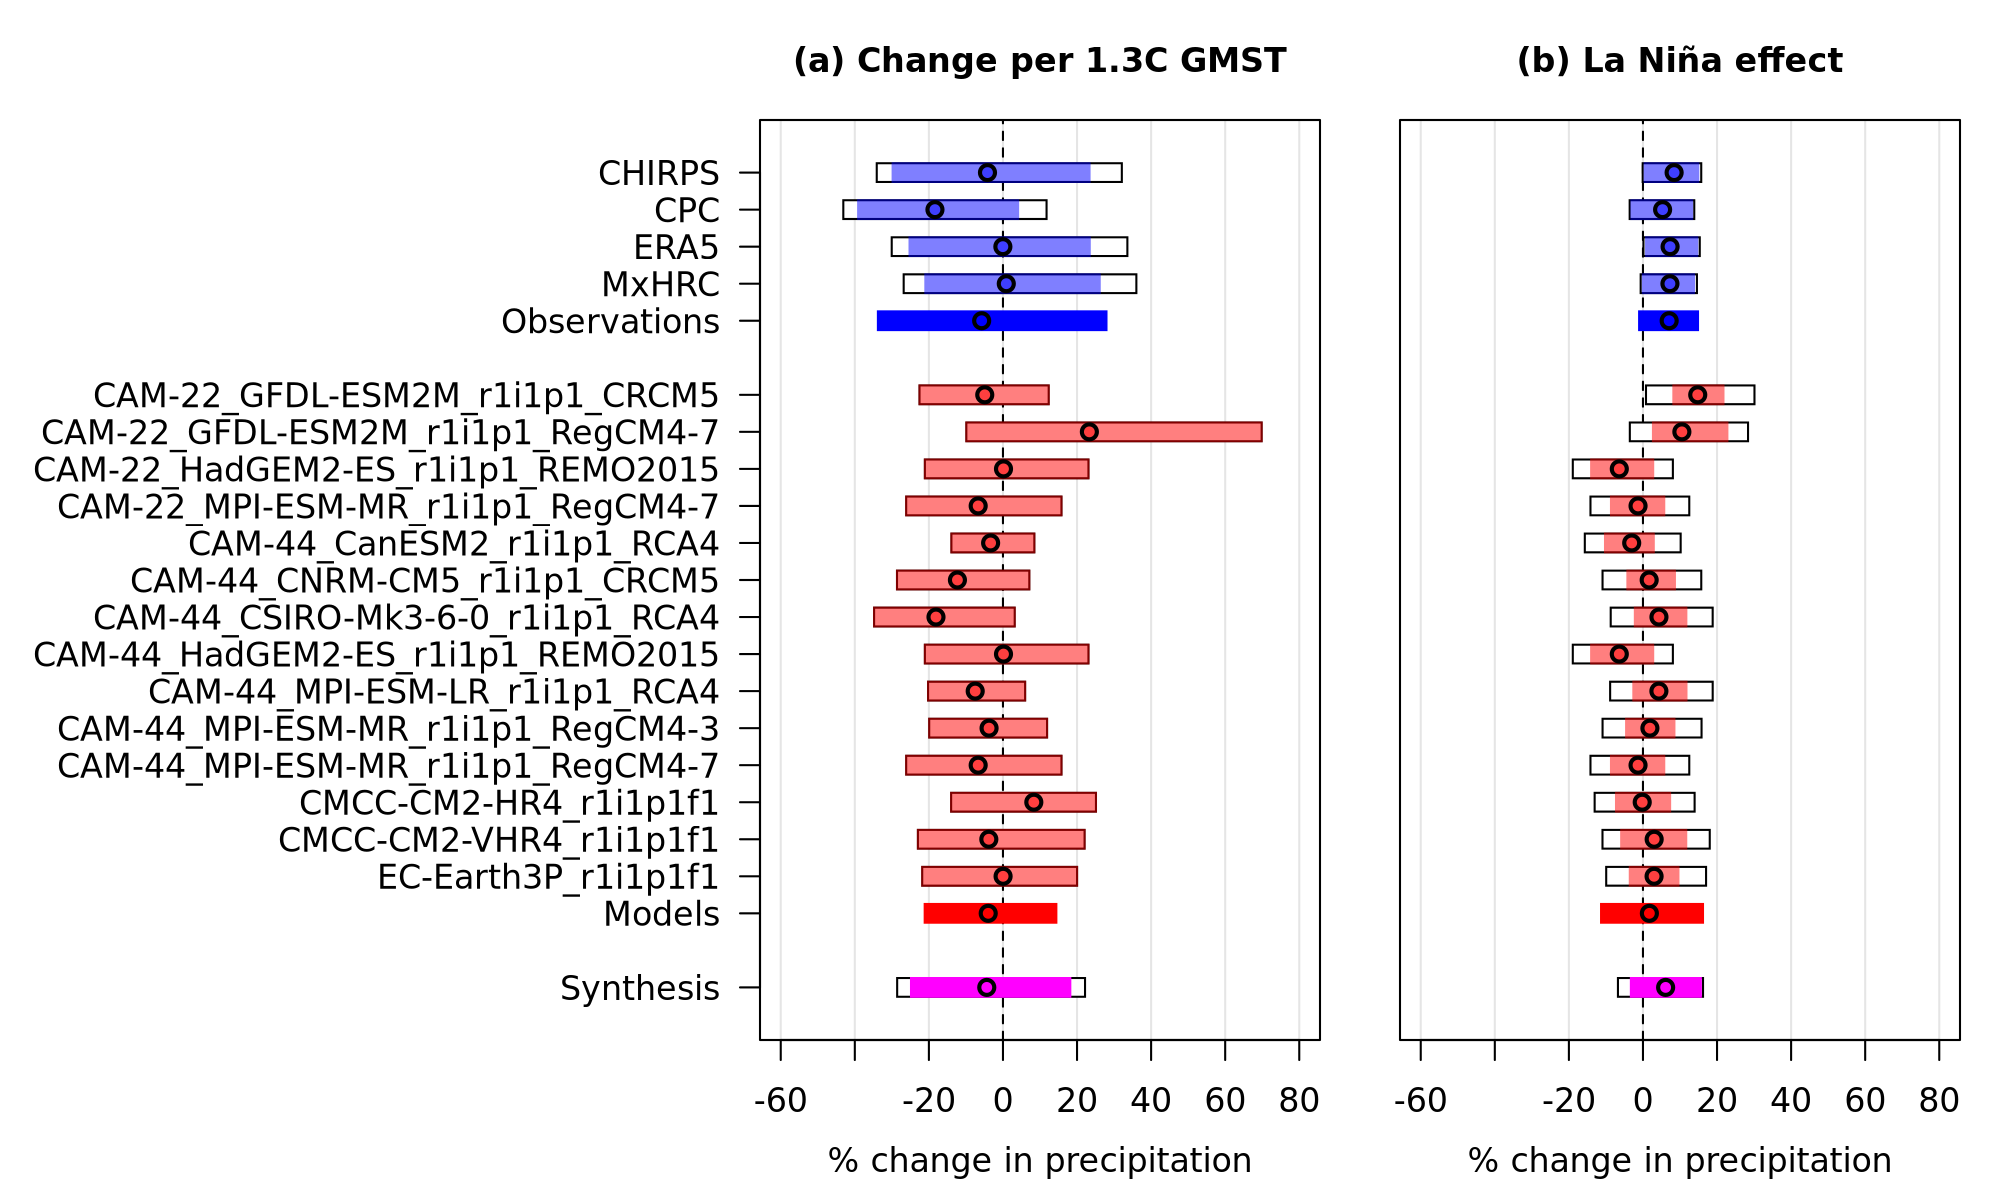

In [185]:
varnm <- "pr-jjaso"

gmst_attr_rel <- read.csv(paste0("synth/synth-1979_alpha-gmst_",varnm,"_gmst+nino_attr_rel.csv"))
gmst_attr_pr <- read.csv(paste0("synth/synth-1979_alpha-gmst_",varnm,"_gmst+nino_attr_PR.csv"))

nino_attr_rel <- read.csv(paste0("synth/synth-1979_alpha-nino_",varnm,"_gmst+nino_attr_rel.csv"))
nino_attr_pr <- read.csv(paste0("synth/synth-1979_alpha-nino_",varnm,"_gmst+nino_attr_PR.csv"))

gmst_proj_rel <- read.csv(paste0("synth/synth-1979_alpha-gmst_",varnm,"_gmst+nino_proj_rel.csv"))
gmst_proj_pr <- read.csv(paste0("synth/synth-1979_alpha-gmst_",varnm,"_gmst+nino_proj_PR.csv"))

res <- 240

xlim_di <- list("pr-jjaso" = c(-60,80), "rx3day" = c(-80,120))[[varnm]]
xlim_pr <- list("pr-jjaso" = c(1e-4, 1e4), "rx3day" = c(1e-4, 1e4))[[varnm]]



# png(paste0("fig/synth-1979_",varnm,"_attr_rel.png"), height = res*1.85, width = res*3); {
    prep_window(c(1,2), mar = c(4,1,3,1), oma = c(0,18,0,0), h = 6, w = 5)
    
    plot_synthesis(gmst_attr_rel[1:(nrow(gmst_attr_rel)-1),], xlim = xlim_di)
    mtext("% change in precipitation", side = 1, line = 2.5)
    mtext("(a) Change per 1.3C GMST", side = 3, line = 1, font = 2)
    
    plot_synthesis(nino_attr_rel[1:(nrow(nino_attr_rel)-1),], hide_labels = T, xlim = xlim_di)
    mtext("% change in precipitation", side = 1, line = 2.5)
    mtext("(b) La Niña effect", side = 3, line = 1, font = 2)

# }; dev.off()

# png(paste0("fig/synth_",varnm,"_attr_pr.png"), height = res*1.85, width = res*3); {
#     prep_window(c(1,2), mar = c(4,1,3,1), oma = c(0,18,0,0), h = 6, w = 5)
    
#     plot_synthesis(gmst_attr_pr[1:(nrow(gmst_attr_pr)-1),], xlim = xlim_pr, log = T)
#     mtext("Probability ratio", side = 1, line = 2.5)
#     mtext("(a) Change per 1.3C GMST", side = 3, line = 1, font = 2)
    
#     plot_synthesis(nino_attr_pr[1:(nrow(nino_attr_pr)-1),], hide_labels = T, xlim = xlim_pr, log = T)
#     mtext("Probability ratio", side = 1, line = 2.5)
#     mtext("(b) La Niña effect", side = 3, line = 1, font = 2)

# }; dev.off()

# png(paste0("fig/synth_",varnm,"_proj.png"), height = res*1.85, width = res*3); {
#     prep_window(c(1,2), mar = c(4,1,3,1), oma = c(0,18,0,0), h = 6, w = 5)
    
#     plot_synthesis(gmst_proj_rel, xlim = xlim_di)
#     mtext("% change in precipitation", side = 1, line = 2.5)
#     mtext("(a) Change in intensity", side = 3, line = 1, font = 2)

#     plot_synthesis(gmst_proj_pr, xlim = xlim_pr, log = T, hide_labels = T)
#     mtext("Probability ratio", side = 1, line = 2.5)
#     mtext("(b) Probability ratio", side = 3, line = 1, font = 2)

# }; dev.off()



In [186]:
gmst_rel <- rbind(gmst_attr_rel[grepl("synth", gmst_attr_rel$group),3:5],
                     gmst_proj_rel[grepl("synth", gmst_proj_rel$group),3:5])
nino_rel <- rbind(nino_attr_rel[grepl("synth", nino_attr_rel$group),3:5],
                     rep(NA, 3))
gmst_pr <- rbind(gmst_attr_pr[grepl("synth", gmst_attr_pr$group),3:5],
                     gmst_proj_pr[grepl("synth", gmst_proj_pr$group),3:5])
nino_pr <- rbind(nino_attr_pr[grepl("synth", nino_attr_pr$group),3:5],
                     rep(NA, 3))

In [187]:
sapply(c("gmst_rel", "nino_rel", "gmst_pr", "nino_pr"),
       function(rtype) apply(signif(get(rtype), 2), 1, function(r) paste0(r[1], " (",r[2], ", ", r[3], ")")))

,gmst_rel,nino_rel,gmst_pr,nino_pr
5,"-5.8 (-31, 25)","7.1 (1.5, 12)","0.57 (0.0067, 18)","3 (1.1, 14)"
20,"-4 (-19, 12)","1.7 (-8.8, 14)","0.53 (0.19, 4)","1.2 (0.33, 4.9)"
21,"-4.4 (-22, 16)","6.1 (-0.73, 13)","0.54 (0.081, 5.2)","2 (0.63, 8.7)"
15,"0.21 (-12, 12)","NA (NA, NA)","1.1 (0.25, 3.3)","NA (NA, NA)"


In [188]:
gmst_attr_rel[grepl("synth", gmst_attr_rel$group),3:5]


,est,lower,upper
,<dbl>,<dbl>,<dbl>
5,-5.750415,-31.23390,25.41683
20,-3.981229,-18.60291,11.88342
21,-4.371312,-22.29355,15.64838


In [195]:
range(gmst_proj_rel$est)

[1] -10.95073  14.03189

# Tables of all results

In [299]:
mtype <- "gmst+nino"
varnm <- "pr-jjaso"

# load obs & relabel properly
res_obs <- read.csv(paste0("res-obs_",varnm,"_",mtype,".csv"), row.names = "X")
colnames(res_obs) <- gsub("ninoneut", "neut", colnames(res_obs))
rownames(res_obs) <- gsub("MXHIGHRESCLIMDB", "MxHRC", toupper(gsub(".+_","",rownames(res_obs))))
res_obs <- res_obs[rownames(res_obs) != "ERA5-1979",]

# load models & filter by model evaluation
res_mdl <- read.csv(paste0("res-models-evaluated_",varnm,"_",mtype,".csv"), row.names = "X")
res_mdl <- res_mdl[!is.na(res_mdl$include),]
res_mdl <- res_mdl[res_mdl$include == "Y",]

cnm_ext <- c("gmst-only" = "", "gmst+nino" = ".pi")[mtype]

In [300]:
dI_rel_attr <- apply(rbind(res_obs[,grepl("dI.rel.pi", colnames(res_obs))], 
              setNames(res_mdl[,grepl("dI.rel.pi", colnames(res_mdl))], colnames(res_obs)[grepl("dI.rel.pi", colnames(res_obs))])),
              1, function(r) {r <- signif(r, 2); paste0(r[1], " (",r[2], ", ", r[3], ")")})

dI_rel_proj <- c(setNames(rep(NA, nrow(res_obs)), c("proj_dI.rel_est","proj_dI.rel_lower","proj_dI.rel_upper")), 
              apply(res_mdl[,grepl("proj_dI.rel", colnames(res_mdl))], 1, function(r) {r <- signif(r, 2); paste0(r[1], " (",r[2], ", ", r[3], ")")}))

PR_attr <- apply(rbind(res_obs[,grepl("PR.pi", colnames(res_obs))], 
              setNames(res_mdl[,grepl("PR.pi", colnames(res_mdl))], colnames(res_obs)[grepl("PR.pi", colnames(res_obs))])),
              1, function(r) {r <- signif(r, 2); paste0(r[1], " (",r[2], ", ", r[3], ")")})

PR_proj <- c(setNames(rep(NA, nrow(res_obs)), c("proj_PR_est","proj_PR_lower","proj_PR_upper")), 
              apply(res_mdl[,grepl("proj_PR", colnames(res_mdl))], 1, function(r) {r <- signif(r, 2); paste0(r[1], " (",r[2], ", ", r[3], ")")}))

dI_rel_nino <- apply(rbind(res_obs[,grepl("dI.rel.neut", colnames(res_obs))], 
              setNames(res_mdl[,grepl("dI.rel.neut", colnames(res_mdl))], colnames(res_obs)[grepl("dI.rel.neut", colnames(res_obs))])),
              1, function(r) {r <- signif(r, 2); paste0(r[1], " (",r[2], ", ", r[3], ")")})

PR_nino <- apply(rbind(res_obs[,grepl("PR.neut", colnames(res_obs))], 
              setNames(res_mdl[,grepl("PR.neut", colnames(res_mdl))], colnames(res_obs)[grepl("PR.neut", colnames(res_obs))])),
              1, function(r) {r <- signif(r, 2); paste0(r[1], " (",r[2], ", ", r[3], ")")})

In [301]:
data.frame(dI_rel_attr,dI_rel_proj,dI_rel_nino,  PR_attr, PR_proj, PR_nino, row.names = gsub("_r1i1p1_", " ", names(dI_rel_attr)))

,dI_rel_attr,dI_rel_proj,dI_rel_nino,PR_attr,PR_proj,PR_nino
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
CHIRPS,"-4.2 (-27, 21)",NA,"8.4 (3, 12)","0.57 (0.0034, 17)",NA,"4.2 (1.6, 29)"
CPC,"-18 (-37, 1.6)",NA,"5.3 (-0.59, 11)","0.16 (0.0044, 1.2)",NA,"2.2 (0.93, 8)"
ERA5,"15 (0.96, 32)",NA,"7.9 (4.1, 12)","4.1 (1.1, 25)",NA,"1.9 (1.3, 3.6)"
MxHRC,"-18 (-28, -5.1)",NA,"7.4 (3.5, 11)","0.18 (0.019, 0.7)",NA,"3.3 (1.7, 8.9)"
CAM-22_GFDL-ESM2M CRCM5,"-4.9 (-20, 9.8)","-1.9 (-12, 6.1)","15 (11, 19)","0.6 (0.21, 4)","0.82 (0.21, 1.8)","7.6 (3.8, 19)"
CAM-22_GFDL-ESM2M RegCM4-7,"23 (-7.4, 67)","14 (0.61, 25)","11 (5.2, 20)","17 (0.52, 1500000)","2.8 (1.1, 5.1)","3 (1.7, 14)"
CAM-22_HadGEM2-ES REMO2015,"0.15 (-19, 21)","6.4 (-2.4, 14)","-6.4 (-11, 0.23)","1 (0.25, 11)","1.7 (0.79, 2.7)","0.58 (0.38, 1)"
CAM-22_MPI-ESM-MR RegCM4-7,"-6.7 (-24, 13)","-1.3 (-11, 5.6)","-1.3 (-6.1, 3.2)","0.51 (0.16, 6.3)","0.87 (0.27, 1.8)","0.86 (0.52, 1.5)"
CAM-44_CanESM2 RCA4,"-3.3 (-11, 5.9)","-6.1 (-9.7, -2.2)","-3 (-7.7, 0.39)","0.68 (0.31, 2.2)","0.41 (0.21, 0.73)","0.71 (0.44, 1)"
